In [1]:
# Import all libraries

import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

In [41]:
# # Interesting Atoms as input

# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-55k-65k.npy"
# data = np.load(filePath)
# data.shape

In [42]:
# Rings centers as input

filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\ring_centers_200k-400k.npy"
data = np.load(filePath)
data.shape

(200000, 236, 3)

In [43]:
# Transpose the data for Convoy algorithm

transposed_data = list()
for x in range(len(data[1])):
    
    transposed_data.append(data[:,x,0:3].tolist())

convoy_data = transposed_data


In [44]:
# View Data Shape
check_convoy_data = np.array(convoy_data)
check_convoy_data.shape

(236, 200000, 3)

In [45]:
# cluster = DBSCAN(eps=9, min_samples=4).fit(data[0])

# print("Number of Clusters = ", max(cluster.labels_)+1)

In [46]:
class ConvoyCandidate(object):
    """
    Attributes:
        indices(set): The object indices assigned to the convoy
        is_assigned (bool):
        start_time (int):  The start index of the convoy
        end_time (int):  The last index of the convoy
    """
    __slots__ = ('indices', 'is_assigned', 'start_time', 'end_time')

    def __init__(self, indices, is_assigned, start_time, end_time):
        self.indices = indices
        self.is_assigned = is_assigned
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return '<%r %r indices=%r, is_assigned=%r, start_time=%r, end_time=%r>' % (self.__class__.__name__, id(self), self.indices, self.is_assigned, self.start_time, self.end_time)

In [47]:
class CMC(object):
    """Coherence Moving Cluster (CMC) algorithm

    Attributes:
        k (int):  Min number of consecutive timestamps to be considered a convoy
        m (int):  Min number of elements to be considered a convoy
    """
    def __init__(self, clf, k, m):
        self.clf = clf
        self.k = k
        self.m = m

    def fit_predict(self, X, y=None, sample_weight=None):
        convoy_candidates = set()
        columns = len(X[0])
        column_iterator = range(columns)
        output_convoys = []

        for column in column_iterator:
            current_convoy_candidates = set()
            values = [row[column] if isinstance(row[column], (list, set)) else [row[column]] for row in X]
            if len(values) < self.m:
                continue
            clusters = self.clf.fit_predict(values, y=y, sample_weight=sample_weight)
            unique_clusters = set(clusters)
            clusters_indices = dict((cluster, ConvoyCandidate(indices=set(), is_assigned=False, start_time=None, end_time=None)) for cluster in unique_clusters)

            for index, cluster_assignment in enumerate(clusters):
                clusters_indices[cluster_assignment].indices.add(index)

            # update existing convoys
            for convoy_candidate in convoy_candidates:
                convoy_candidate_indices = convoy_candidate.indices
                convoy_candidate.is_assigned = False
                for cluster in unique_clusters:
                    cluster_indices = clusters_indices[cluster].indices
                    cluster_candidate_intersection = cluster_indices & convoy_candidate_indices
                    if len(cluster_candidate_intersection) < self.m:
                        continue
                    convoy_candidate.indices = cluster_candidate_intersection
                    current_convoy_candidates.add(convoy_candidate)
                    convoy_candidate.end_time = column
                    clusters_indices[cluster].is_assigned = convoy_candidate.is_assigned = True

                # check if candidates qualify as convoys
                candidate_life_time = (convoy_candidate.end_time - convoy_candidate.start_time) + 1
                if (not convoy_candidate.is_assigned or column == column_iterator[-1]) and candidate_life_time >= self.k:
                    output_convoys.append(convoy_candidate)

            # create new candidates
            for cluster in unique_clusters:
                cluster_data = clusters_indices[cluster]
                if cluster_data.is_assigned:
                    continue
                cluster_data.start_time = cluster_data.end_time = column
                current_convoy_candidates.add(cluster_data)
            convoy_candidates = current_convoy_candidates
        return output_convoys

In [48]:
# Clustering using DBSCAN
clustering_clf = DBSCAN(eps=8)


In [49]:
# Min elements for convoy = m
# Min consecutive timesteps = k

clf = CMC(clustering_clf, k=50,m=30)

# Convoy calculation using Test data
convoys = clf.fit_predict(convoy_data)
print("Total number of Convoys =", len(convoys))

Total number of Convoys = 843


In [50]:
# file = open("convoys_rings_200-400k_modified code.txt", "w")
# file.write(f"Total number of Convoys: {len(convoys)}\n")
# j = 0
# for convoy in convoys:
#     file.write(f"{j}. No of elements: {len(convoy.indices)}, Elements ID: {convoy.indices}, Start Time:{convoy.start_time}, End Time: {convoy.end_time}\n")
#     j = j+1
# #     for i in convoy.indices:
# #         print(f"{i}, {data[i]}, - Start Time: {convoy.start_time}, End Time: {convoy.end_time}")

# ##     file.write('%r - S: %r, E: %r\n' % (convoy.indices, convoy.start_time, convoy.end_time))
# file.close()

In [60]:
# drugName = "SFL11"

# #load HB info and extract the information for 3 interesting atoms - this will help filter out the convoys in the next cell

# dfHB = pd.read_csv(r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\longestHBatomid.csv")
# drugInfo = dfHB[dfHB["drug"] == drugName]
# # threeAtoms = ["nitrogen_atom_id", "hydrogen_atom_id", "oxygen_atom_id"]

# twoAtoms = ["nitrogen_ring_id", "oxygen_ring_id"]

In [61]:
# outputFilename = "ring convoys with SFL 11 longest HB.txt"

# with open(outputFilename, 'w') as f:
#     with redirect_stdout(f):
#         for convoy in convoys:
#             for x in drugInfo[twoAtoms].values:
#                 if all(elem in list(convoy.indices) for elem in x):
#                     indices = list(convoy.indices)
#                     indices.sort()
#                     print(f"Convoy has {len(convoy.indices)} elements starting at {convoy.start_time} and ending at {convoy.end_time}")
#                     print(indices)
#                     continue
                    
# f.close()
# print(f"Written to {outputFilename}")

Written to ring convoys with SFL 11 longest HB.txt


In [53]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data[1500])
distances, indices = nbrs.kneighbors(data[1500])

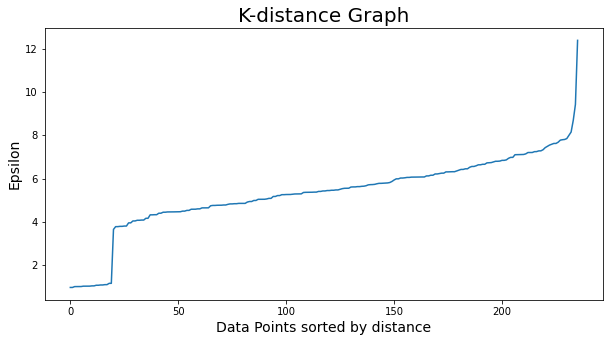

In [54]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()